In [1]:
import mesa
import random
import pickle
import time
import seaborn as sns
import numpy as np
import pandas as pd
import math
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
import folium
import folium.plugins
import panel as pn
import panel.widgets as pnw
pn.extension()
import threading
import statistics

import warnings
warnings.filterwarnings('ignore')

In [2]:
class MaleAdult(mesa.Agent):

    def __init__(self, abandoned, borders, homesickness, home, unique_id, model):
        # Pass the parameters to the parent class.
        super().__init__(unique_id, model)

        self.infected = False
        self.days = None
        self.antibody = 0
        self.abandoned = abandoned
        self.borders = borders
        self.homesickness = homesickness
        self.home = home
        self.iter = 0
        
    def step(self):
        self.iter += 1
        if self.antibody > 0 and not self.infected:
            self.antibody -= 1
            #if self.antibody == 0:
            #   print(f"I'm agent {str(self.unique_id)} in {str(self.pos)} and I can be infected again") 
            #else:
            #    print(f"I'm agent {str(self.unique_id)} in {str(self.pos)} and I currently have antibodies for {str(self.antibody)} more days") 
        
        if self.infected:
            if self.days is None:
                self.days = self.model.recovery_days
            a = random.randint(1,100)
            if a <= self.model.cont_rate:
                other_agent = self.random.choice(self.model.grid.get_cell_list_contents([self.pos]))
                if other_agent is not None and not other_agent.infected and other_agent.antibody == 0:
                    #print(f"I'm agent {str(self.unique_id)} in {str(self.pos)} and I spread the infection to {str(other_agent.unique_id)} which is in {str(other_agent.pos)}")
                    other_agent.infected = True
                    #other_agent.days = model.recovery_days
                    self.model.num_infected += 1
            
            #print(f"I'm agent {str(self.unique_id)} in {str(self.pos)} and i'm infected, let's see if I die")
            b = random.randint(0,10000)
            if self.antibody > 0: #vaccination
                b/=2
            if b < (self.model.death_rate*100):
                #print(f"I'm agent {str(self.unique_id)} in {str(self.pos)} and I'm dead")
                self.model.kill_agents.append(self)
            else:
                if self.days is not None:
                    self.days -= 1
                    if self.days == 0:
                        #print(f"I'm agent {str(self.unique_id)} in {str(self.pos)} and I'm cured")
                        self.infected = False
                        self.days = None
                        self.model.num_infected -= 1
                        self.antibody = self.model.antibody_days
        
        if self.antibody == 0 and self.model.vaccination and self.iter >= self.model.vac_active:
            
            c = random.randint(1,100)
            if c <= self.model.vac_perc:
                self.antibody = self.model.vac_eff
        self.move()
                    
    def move(self):
        if self.borders is True and (self.model.move_inf or not self.infected or self.days >= math.ceil(2*self.model.recovery_days/3)):
            neighborhoods = self.model.grid.get_neighborhood(
                self.pos,
                include_center=False)
            
            if self.abandoned:
                possible_steps = neighborhoods
            else:
                possible_steps = [city for city in neighborhoods if city not in model.dead_cities]
                if not possible_steps:
                    return
                
            if self.homesickness and self.pos != self.home:
                if len(self.model.G.nodes[self.home]['agent']) > 0:
                    new_position = self.home
                else:
                    self.homesickness = False
                    new_position = self.random.choice(possible_steps)    
                    if self.home not in model.dead_cities:
                        model.dead_cities.append(self.home)
            else:
                new_position = self.random.choice(possible_steps)
            
            
            distance = self.model.G[self.pos][new_position]["KM_TOT"]
            pop = len(self.model.G.nodes[new_position]['agent'])
            total_pop = self.model.total_agents
            
        
            if self.abandoned is True or pop > 0:
                prob_mov = 10 + (100*pop)/(4*distance*total_pop)
                r = random.randint(1, 100)
                if prob_mov >= r:
                     #print(f"I'm agent {str(self.unique_id)} and I moved")
                     #print("Actual position: " + self.pos)
                      #print("New position: " + new_position)
                      #print("Value of r: " + str(r))
                      #print("Probability of moving: " + str(prob_mov))
                      #print("Distance: " + str(distance) + " Population: " + str(pop))
                     self.model.grid.move_agent(self, new_position)        
            else:
                self.model.dead_cities.append(new_position)

In [3]:
with open('distances.gpickle', 'rb') as f:
    G = pickle.load(f)

In [4]:
class NetworkInfectionModel(mesa.Model):

    def __init__(self, G, death_rate=5, recovery_days=5, antibody_days=10, cont_rate=20, init_rate = 1, abandoned = True, borders = True, homesickness = False, 
                 move_inf = True, vaccination = False, vac_active = 100, vac_perc = 1, vac_eff = 60):
        super().__init__()
        self.recovery_days = recovery_days
        self.antibody_days = antibody_days
        self.death_rate = death_rate
        self.cont_rate = cont_rate
        self.num_infected = 0
        self.num_dead = 0
        self.total_agents = 0
        self.steps = 0
        self.abandoned = abandoned
        self.borders = borders
        self.homesickness = homesickness
        self.move_inf = move_inf
        self.vaccination = vaccination
        self.vac_active = vac_active
        self.vac_perc = vac_perc
        self.vac_eff = vac_eff
        
        self.lat = []
        self.lng = []
        self.province = None
        
        self.dead_cities = []

        self.G = G
        self.grid = mesa.space.NetworkGrid(self.G)

        self.schedule = mesa.time.RandomActivation(self)
        self.kill_agents = []

        # Create agents
        for i, node in enumerate(self.G.nodes(data = True)):
            node_dict = node[1]
            node_lat = node_dict.get('lat')
            #if node_lat is None:
            #    print("We: " + node[0])
            node_lng = node_dict.get('lng')
            self.lat.append(node_lat)
            self.lng.append(node_lng)
            population = node_dict['popolazione']
            #print(node[0] + " will have "+ str(round(population/1000)) + " agents")
            for x in range(math.ceil(population/1000)):
               a = MaleAdult(self.abandoned, self.borders, self.homesickness, node[0], i+1, self)
               self.schedule.add(a) 
               self.total_agents += 1
               self.grid.place_agent(a, node[0])
               r = random.randint(0, 100)
               if r <= init_rate:
                   a.infected = True
                   self.num_infected += 1
                   a.days = self.recovery_days
                    
            self.datacollector = mesa.DataCollector(
            model_reporters={"Total Agents": "total_agents", "Infected": "num_infected", "Dead": "num_dead"},
            agent_reporters={"Position": "pos", "Infected": "infected"})
            #self.datacollector.collect(self)

    def step(self):
        self.schedule.step()
        for x in self.kill_agents[:]:
            self.grid.remove_agent(x)
            self.schedule.remove(x)
            self.kill_agents.remove(x)
            self.num_infected -= 1 
            self.num_dead += 1
            self.total_agents -= 1
        self.running = True
        self.datacollector.collect(self)
        #print(f"Current number of total agents is: {str(self.total_agents)}")
        #print(f"Current number of infected agents is: {str(self.num_infected)}")
        #print(f"Current number of dead agents is: {str(self.num_dead)}")
        #for node in enumerate(self.G.nodes(data = True)):
        #   print(node[1][0] + ": " + str(len(node[1][1]['agent'])))         

In [5]:
model = NetworkInfectionModel(G)

In [6]:
def city_map():
    latitude = statistics.mean(model.lat)
    longitude = statistics.mean(model.lng)

    province_map = folium.Map(width=600, height=600, location=[latitude, longitude], zoom_start=10)


    # loop through the dataframe and add each data point to the mark cluster
    for node in enumerate(model.G.nodes(data = True)):
            node_dict = node[1][1]
            lat = node_dict.get('lat')
            lng = node_dict.get('lng')
            infected = 0
            agent_list = node_dict.get('agent')
            pop = len(agent_list)
            for agent in agent_list:
                if agent.infected:
                    infected += 1
            if pop == 0:
                color = 'gray'
            elif 0 < pop <= 5:
                color = 'blue'
            elif 5 < pop < 20:
                color = 'orange'
            else:
                color = 'red'
            #print(node[1][0])
            folium.CircleMarker(
            location=[lat, lng],
            radius=10,
            fill=True,
            color = color,
            popup=folium.Popup(f"{node[1][0]}<br>Infected: {str(infected)}<br>Total: {str(pop)}", max_width=300),
        ).add_to(province_map)

    return province_map

In [7]:
def get_province(model):
    max_agents = 0
    province = None

    for node in model.G.nodes(data=True):
        city_name = node[0]
        num_agents = len(node[1]['agent'])
        if num_agents > max_agents:
            max_agents = num_agents
            province = city_name
    
    return province

Row(sizing_mode='stretch_width')
    [0] Column
        [0] WidgetBox
            [0] Button(button_type='primary', name='Run', width=200)
            [1] Button(button_type='warning', name='Pause', width=200)
            [2] StaticText(name='Province', value='Milano')
            [3] StaticText(name='Biggest City', value='Milano')
            [4] StaticText(name='Current Step', value='0')
            [5] FloatSlider(name='Death Rate', step=0.01, value=0.1, width=200)
            [6] IntSlider(end=30, name='Recovery Days', start=1, value=10, width=200)
            [7] IntSlider(end=30, name='Antibody Days', width=200)
            [8] IntSlider(end=100, name='Cont. Rate', start=1, value=30, width=200)
            [9] IntSlider(end=100, name='Init. Rate', start=1, value=1, width=200)
            [10] IntSlider(end=5000, name='Steps', start=5, value=200, width=200)
            [11] FloatSlider(end=2, name='Delay', width=200)
            [12] Checkbox(name='Move to Abandoned City')
            [13] Checkbox(name='Open Borders', value=True)
            [14] Checkbox(name='Home Sickness', value=True)
            [15] Checkbox(name='Infected Can M..., value=True)
            [16] Checkbox(name='Activate Vaccination')
            [17] IntSlider(end=5000, name='Vaccination a..., start=1, value=1, width=200)
            [18] IntSlider(end=100, name='Percentage of V..., start=1, value=1, width=200)
            [19] IntSlider(end=100, name='Antibody Days V..., start=1, value=1, width=200)
    [1] Folium(Map, height=600, sizing_mode='fixed', width=600)
    [2] Matplotlib(Figure, height=300, sizing_mode='fixed', width=400)
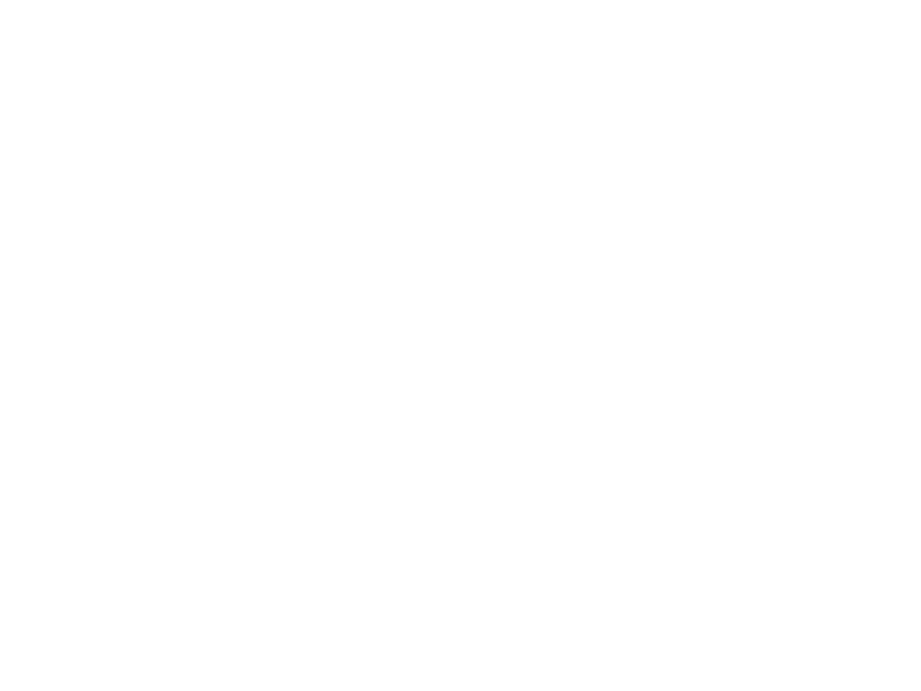

In [8]:
def toggle_pause(event):
    global is_paused
    is_paused = not is_paused
    pause_btn.name = 'Resume' if is_paused else 'Pause'

def run_model_thread(model, death, recovery, antibody, cont, init, steps, delay, abandoned, borders, home, move_inf, vaccination, vac_active, vac_perc, vac_eff):
    global current_step, is_paused, big_city

    # Crea un nuovo modello
    model = NetworkInfectionModel(G, death_rate=death, recovery_days=recovery, antibody_days=antibody, cont_rate=cont, init_rate=init, abandoned=abandoned, borders = borders, homesickness = home, move_inf = move_inf, vaccination = vaccination, vac_active=vac_active, vac_perc = vac_perc, vac_eff = vac_eff)

    # Reset del contatore degli step
    current_step = 0

    # Creazione di una figura per il grafico di Seaborn
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.set_title("Agents Status Over Time")
    ax.set_xlabel("Step")
    ax.set_ylabel("Number of Agents")

    # Ciclo di esecuzione del modello
    for i in range(steps):
        while is_paused:
            time.sleep(0.1)
        # Esegui uno step del modello
        model.step()
        
        current_step += 1
        big_city = get_province(model)
        city_text.value = f'{big_city}'
        step_counter.value = f'{current_step}'

        # Aggiorna i dati del grafico di Seaborn
        agents = model.datacollector.get_model_vars_dataframe()
        num_infected = agents['Infected'].iloc[-1]
        num_dead = agents['Dead'].iloc[-1]
        num_total = agents['Total Agents'].iloc[-1]
        ax.clear()  # Pulisce l'asse senza cancellare la figura
        sns.lineplot(x=agents.index, y=agents['Infected'], ax=ax, label=f"Infected \n(Last: {num_infected})")
        sns.lineplot(x=agents.index, y=agents['Dead'], ax=ax, label=f"Dead \n(Last: {num_dead})")
        sns.lineplot(x=agents.index, y=agents['Total Agents'], ax=ax, label=f"Total Agents \n(Last: {num_total})")
        ax.set_title("Agents Status Over Time")
        ax.set_xlabel("Step")
        ax.set_ylabel("Number of Agents")

        # Aggiorna il grafico
        states_pane.object = fig
        states_pane.param.trigger('object')
        
        updated_map = city_map()  # Assicurati che crime_map accetti il modello come parametro
        grid_pane.object = updated_map
        grid_pane.param.trigger('object')

        # Aggiungi un ritardo per la visualizzazione
        time.sleep(delay)
        
        if num_infected <= 0:
            break
    
    position_csv = model.datacollector.get_agent_vars_dataframe().reset_index().pivot(index='AgentID', columns='Step', values='Position')
    position_csv.to_csv('position.csv', index=False)

    infected_csv = model.datacollector.get_agent_vars_dataframe().reset_index().pivot(index='AgentID', columns='Step', values='Infected')
    infected_csv.to_csv('infected.csv', index=False)
    
    fig.savefig(f"Plots/{province}_{time.strftime("%Y%m%d-%H%M%S")}.png") 
    #csv =  model.datacollector.get_agent_vars_dataframe().reset_index().pivot(index='AgentID', columns='Step', values='Position')
    #csv.to_csv('agents.csv', index=False)

# Impostazioni iniziali
current_step = 0
is_paused = False
province_map = city_map()
grid_pane = pn.pane.plot.Folium(province_map, height=600, width=600)
states_pane = pn.pane.Matplotlib(plt.Figure(), width=400, height=300)

province = get_province(model)
big_city = province

province_text = pnw.StaticText(name='Province', value=f'{province}')
city_text = pnw.StaticText(name='Biggest City', value=f'{big_city}')
step_counter = pnw.StaticText(name='Current Step', value=f'{current_step}')
go_btn = pnw.Button(name='Run', width=200, button_type='primary')
pause_btn = pnw.Button(name='Pause', width=200, button_type='warning')
pause_btn.on_click(toggle_pause)
death_input = pnw.FloatSlider(name='Death Rate', value=0.1, start=0, end=1, step=0.01, width=200)
recovery_input = pnw.IntSlider(name='Recovery Days', value=10, start=1, end=30, width=200)
antibody_input = pnw.IntSlider(name='Antibody Days', value=0, start=0, end=30, width=200)
cont_input = pnw.IntSlider(name='Cont. Rate', value=30, start=1, end=100, step=1, width=200)
init_input = pnw.IntSlider(name='Init. Rate', value=1, start=1, end=100, step=1, width=200)
steps_input = pnw.IntSlider(name='Steps', value=200, start=5, end=5000, width=200)
delay_input = pnw.FloatSlider(name='Delay', value=0, start=0, end=2, step=0.1, width=200)
abandoned_input = pnw.Checkbox(name='Move to Abandoned City', value=False)
borders_input = pnw.Checkbox(name='Open Borders', value=True)
home_input = pnw.Checkbox(name='Home Sickness', value=True)
move_inf_input = pnw.Checkbox(name='Infected Can Move after 1/3 Recovery', value=True)
vaccination_input = pnw.Checkbox(name='Activate Vaccination', value=False)
vac_active_input = pnw.IntSlider(name='Vaccination after # Steps', value=1, start=1, end=5000, width=200)
vac_perc_input = pnw.IntSlider(name='Percentage of Vaccination', value=1, start=1, end=100, width=200)
vac_eff_input = pnw.IntSlider(name='Antibody Days Vaccination', value=1, start=1, end=100, width=200)
widgets = pn.WidgetBox(go_btn, pause_btn, province_text, city_text, step_counter, death_input, recovery_input, antibody_input, cont_input, init_input, steps_input, delay_input, abandoned_input, borders_input, home_input, move_inf_input, vaccination_input, vac_active_input, vac_perc_input, vac_eff_input)

def execute(event):
    # Esegui il modello in un thread separato
    threading.Thread(target=run_model_thread, args=(model, death_input.value, recovery_input.value,
                                                    antibody_input.value, cont_input.value, init_input.value, steps_input.value, delay_input.value, abandoned_input.value, borders_input.value, home_input.value, move_inf_input.value, vaccination_input.value, vac_active_input.value, vac_perc_input.value, vac_eff_input.value), daemon=True).start()

go_btn.param.watch(execute, 'clicks')

# Configura il layout
layout = pn.Row(pn.Column(widgets), grid_pane, states_pane, sizing_mode='stretch_width')
layout.servable()